## Random Forest

In [49]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_file
import os
import time
import xgboost as xgb
from xgboost import XGBClassifier as xgbclass
from scipy import stats

# Load dataset
df = pd.read_csv('../../Data/df_heart_drop_imp.csv')

# Load final datasets
X_test_df = pd.read_csv('../../Data/GoogleDrive/X_test.csv')
X_train_df = pd.read_csv('../../Data/GoogleDrive/X_train.csv')
y_test_df = pd.read_csv('../../Data/GoogleDrive/y_test.csv')
y_train_df = pd.read_csv('../../Data/GoogleDrive/y_train.csv')

In [45]:
# Get the number of available CPU cores
num_cores = os.cpu_count()

print("Number of CPU cores available:", num_cores)

# Set number of cores
jobs = 7

Number of CPU cores available: 12


### RF Data Selection

In [4]:
# Show 5 first rows
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,...,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,...,1.70,80.74,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,...,1.60,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,...,1.57,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,Yes,...,1.65,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No


In [5]:
# Data selection
    # From Hinn's code
target = 'HadHeartDisease'
features = df.drop(columns = [target])   
df = pd.get_dummies(df, columns=features.select_dtypes(include=['object']).columns)

# data split
df_train, df_test = train_test_split(df, 
                                    test_size = 0.25, 
                                    random_state = 69,
                                    stratify = df[target])

X_train = df_train.drop(columns = [target])
y_train = df_train[target]
X_test = df_test.drop(columns = [target])
y_test = df_test[target]

### RF Tuning Grid

In [13]:
# Tuning Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [1, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'max_features': ['auto', 'sqrt', 'log2']
    # 'bootstrap': [True, False]
}

param_grid_2 = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [1, 10, 20, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [2, 10, 20],
    'max_features': ['sqrt', 'log2']
    # 'bootstrap': [True, False]
}

# max_features

### RF Model

In [14]:
start_time = time.time()

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=69)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=jobs) # Parallel

# Perform GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model to make predictions on the testing data
best_rf_classifier = grid_search.best_estimator_
predictions = best_rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

/opt/anaconda3/envs/ucla/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/ucla/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
93 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ucla/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/e

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8888557051020125
Accuracy: 0.8890544716487776


### RF ROC AUC

In [27]:
predictions_proba = best_rf_classifier.predict_proba(X_test)
predictions_proba_positive_class = predictions_proba[:, 1]

roc_auc = roc_auc_score(y_test, predictions_proba_positive_class)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8356422034639205


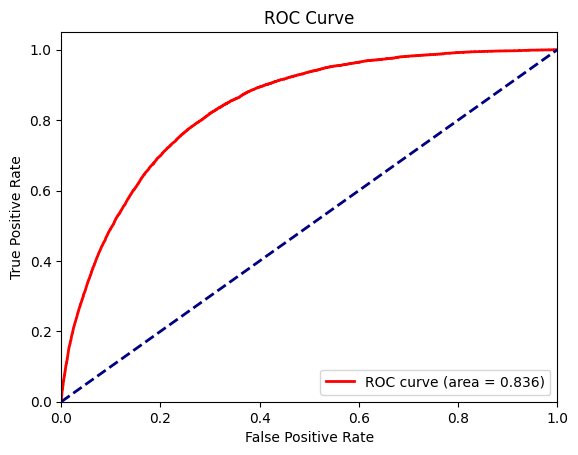

In [36]:
# ROC AUC Curve
# Convert categorical labels to binary labels
y_test_binary = (y_test == 'Yes').astype(int)

# Get predicted probabilities for the positive class
y_probs = best_rf_classifier.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)

# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

save_path = '../../assignment_2/local_dev/figures/'

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, Random Forest')
plt.legend(loc="lower right")

plt.savefig(os.path.join(save_path, "roc_curve_rf.png"))

plt.show()

### RF Confusion Matrix and Classification Report

In [24]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Generate the classification report
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[96295   629]
 [11506   948]]
Classification Report:
              precision    recall  f1-score   support

          No       0.89      0.99      0.94     96924
         Yes       0.60      0.08      0.14     12454

    accuracy                           0.89    109378
   macro avg       0.75      0.53      0.54    109378
weighted avg       0.86      0.89      0.85    109378



### RF Feature Importance

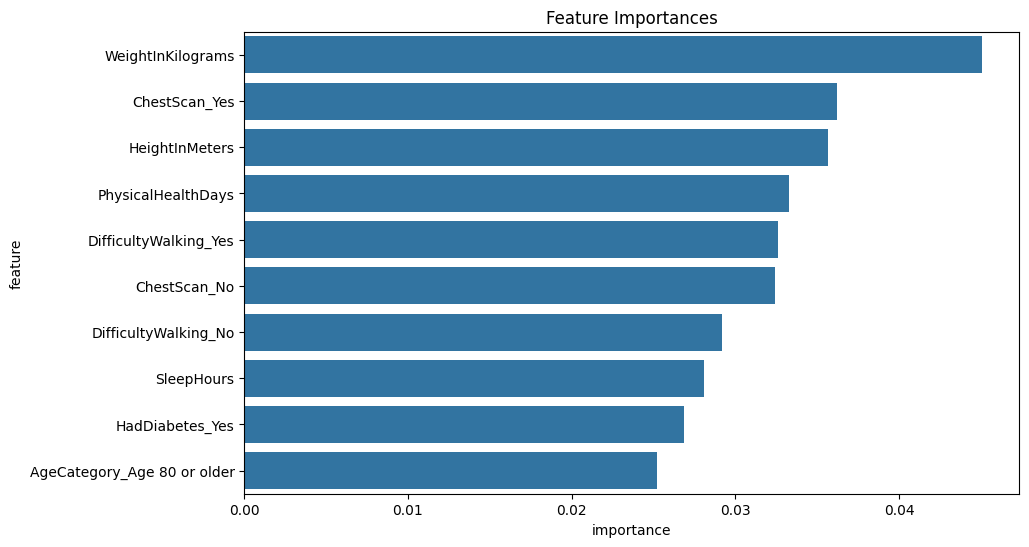

In [19]:
# Feature importance
feature_importances = best_rf_classifier.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_df.head(10))
plt.title('Feature Importances')

plt.savefig(os.path.join(save_path, "feature_importance.png"))

plt.show()

### RF Decision Tree

In [42]:
tree_index = 0  
decision_tree = best_rf_classifier.estimators_[tree_index]

dot_file_path = os.path.join(save_path, f"decision_tree_{tree_index}.dot")

export_graphviz(decision_tree, out_file=dot_file_path, 
                feature_names=X_train.columns,
                filled=True, rounded=True, special_characters=True)

graph = graph_from_dot_file(dot_file_path)

graph.write_png(os.path.join(save_path, f"decision_tree_{tree_index}.png"))

## XGBoost

In [54]:
start_time = time.time()

# Define the hyperparameter grid
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.01, 0.001],
    'subsample': [0.5, 1]
}

# param_grid_2 = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7, 1],
#     # 'n_estimators':stats.randint(50, 200)
# }

# Convert categorical labels to binary labels for training data
y_train_binary = (y_train == 'Yes').astype(int)

# Convert categorical labels to binary labels for testing data
y_test_binary = (y_test == 'Yes').astype(int)

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, 
                           param_grid, 
                           cv=5, 
                           scoring='accuracy',
                           n_jobs=jobs)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train_binary)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 5, 'subsample': 1}
Best score:  0.8861616666121434
Execution time: 23.525800943374634 seconds


In [57]:
# Final XGBoost model

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Use the best model to make predictions on the testing data
predictions = best_xgb_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_binary, predictions)
print("Accuracy:", accuracy)

# Get predicted probabilities for the positive class
y_probs = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)

# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)


Accuracy: 0.886147122821774
ROC AUC Score: 0.8124836540974191


### XG ROC AUC

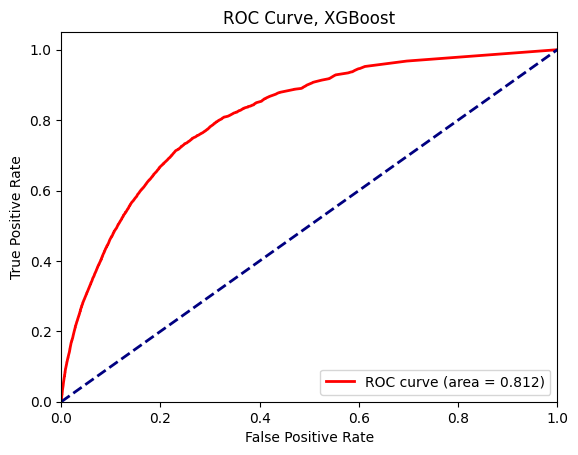

In [58]:
# ROC AUC Curve

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, XGBoost')
plt.legend(loc="lower right")

# plt.savefig(os.path.join(save_path, "roc_curve_xgb.png"))

plt.show()

### XG Confusion Matrix and Classification Report

In [60]:
# Convert categorical labels to binary labels for testing data
y_test_binary = (y_test == 'Yes').astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_binary, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report
class_report = classification_report(y_test_binary, predictions)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[96922     2]
 [12451     3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     96924
           1       0.60      0.00      0.00     12454

    accuracy                           0.89    109378
   macro avg       0.74      0.50      0.47    109378
weighted avg       0.85      0.89      0.83    109378



### XG Feature Importance

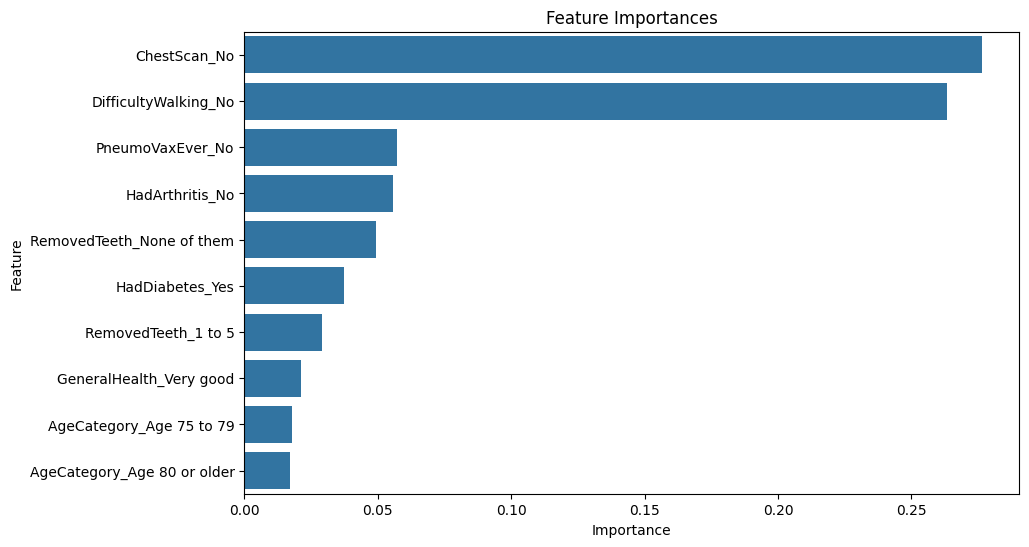

In [63]:
# Get feature importance scores from the XGBoost model
feature_importance = best_xgb_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Feature Importances')

# plt.savefig(os.path.join(save_path, "feature_importance_xgb.png"))

plt.show()

## Saving Models

In [ ]:
# Save the best RF model
# best_rf_model_path = os.path.join(save_path, "best_rf_model.pkl")
# joblib.dump(best_rf_classifier, best_rf_model_path)

# Save the best XGBoost model
# best_xgb_model_path = os.path.join(save_path, "best_xgb_model.pkl")
# joblib.dump(best_xgb_model, best_xgb_model_path)